In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import itertools

import networkx as nx

import preprocess
import info_theory
import network
import backboning

In [2]:
# Define assets and file paths
assets = ["commodity", "credit", "currency", "energy", "equity", "interest", "metals", "real_estate", "volatility"]
file_paths = {asset: f"../data/{asset}_data.xlsx" for asset in assets}

# Load data
aligned_data, tickers = preprocess.load_and_align_data(file_paths)

# Drop tickers with many missing points
aligned_data, tickers = preprocess.drop_short_tickers(aligned_data, tickers, max_nan=50)
aligned_data['GB03'] + 0.1
# Compute log returns
log_returns = preprocess.compute_log_returns(aligned_data)

# Interest data has negative and zero values
#interest_data = aligned_data[tickers['interest']]
#log_returns[tickers["interest"]] = interest_data

# Drop NA
log_returns = log_returns.dropna()

Tickers to drop/replace due to insufficient data:
['FXJPEMCS', 'QCLN']


c:\Users\akhma\OneDrive\Onenote\Python\my_venv\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning:

invalid value encountered in log



In [3]:
tickers_discrete = preprocess.discretize_tickers(log_returns, tickers)

In [5]:
mi_network = network.create_network(tickers_discrete)

100%|██████████| 30/30 [00:00<00:00, 385.98it/s]


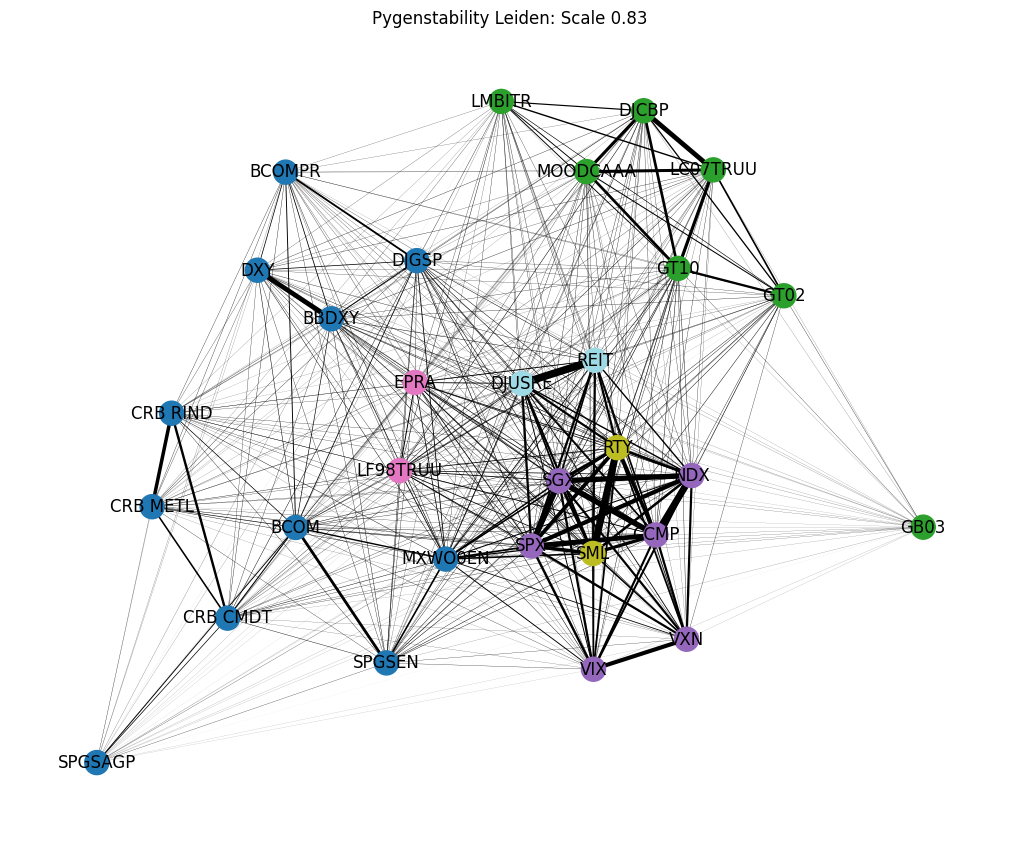

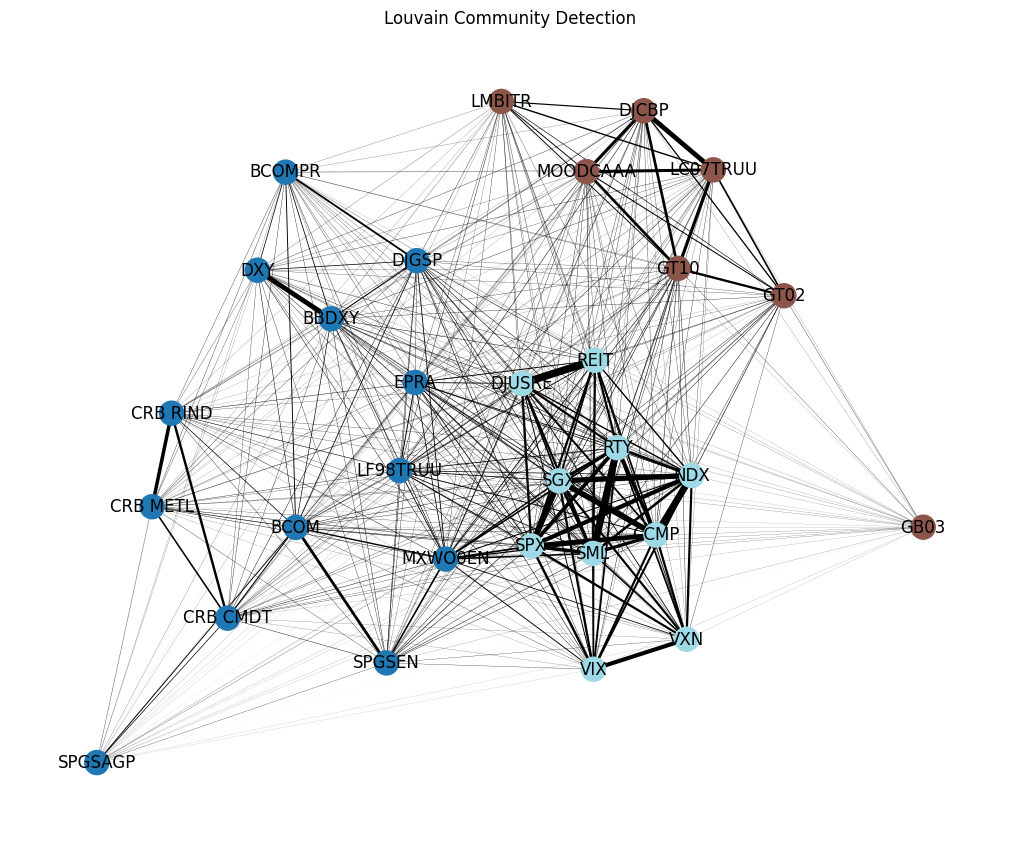

In [6]:
network.custom_plot_communities(mi_network)

In [7]:
true_labels = network.create_true_labels(mi_network, tickers)

In [8]:
network.pgs_optimal_param(mi_network, true_labels, np.linspace(0.3, 0.7, 5))

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 469.34it/s]
c:\Users\akhma\OneDrive\Onenote\Python\my_venv\Lib\site-packages\pygenstability\optimal_scales.py:39: RuntimeWarning:

Mean of empty slice



0.33683155264540127


100%|██████████| 20/20 [00:00<00:00, 421.02it/s]


0.35202296375091874


100%|██████████| 20/20 [00:00<00:00, 444.86it/s]


0.3363224198850388


100%|██████████| 20/20 [00:00<00:00, 415.41it/s]


0.30475094824232085


100%|██████████| 20/20 [00:00<00:00, 433.32it/s]


0.3531869455106534


[np.float64(0.33683155264540127),
 np.float64(0.35202296375091874),
 np.float64(0.3363224198850388),
 np.float64(0.30475094824232085),
 np.float64(0.3531869455106534)]

100%|██████████| 20/20 [00:00<00:00, 440.46it/s]
c:\Users\akhma\OneDrive\Onenote\Python\my_venv\Lib\site-packages\pygenstability\optimal_scales.py:39: RuntimeWarning:

Mean of empty slice



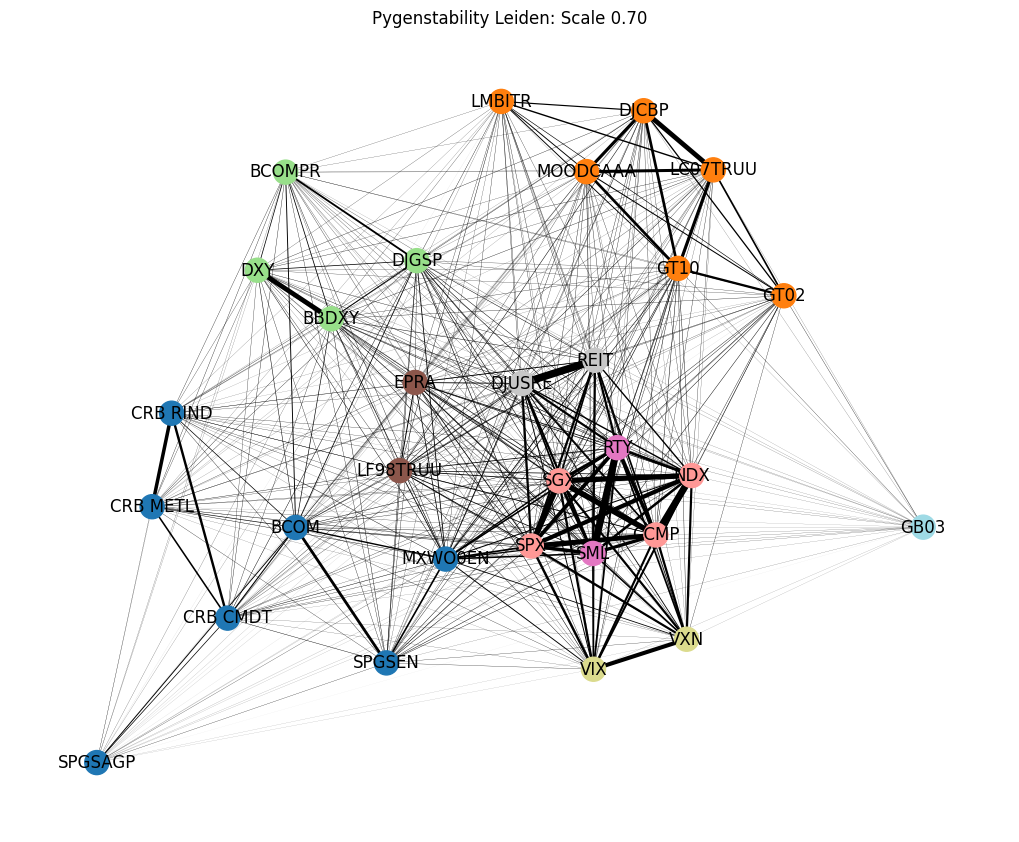

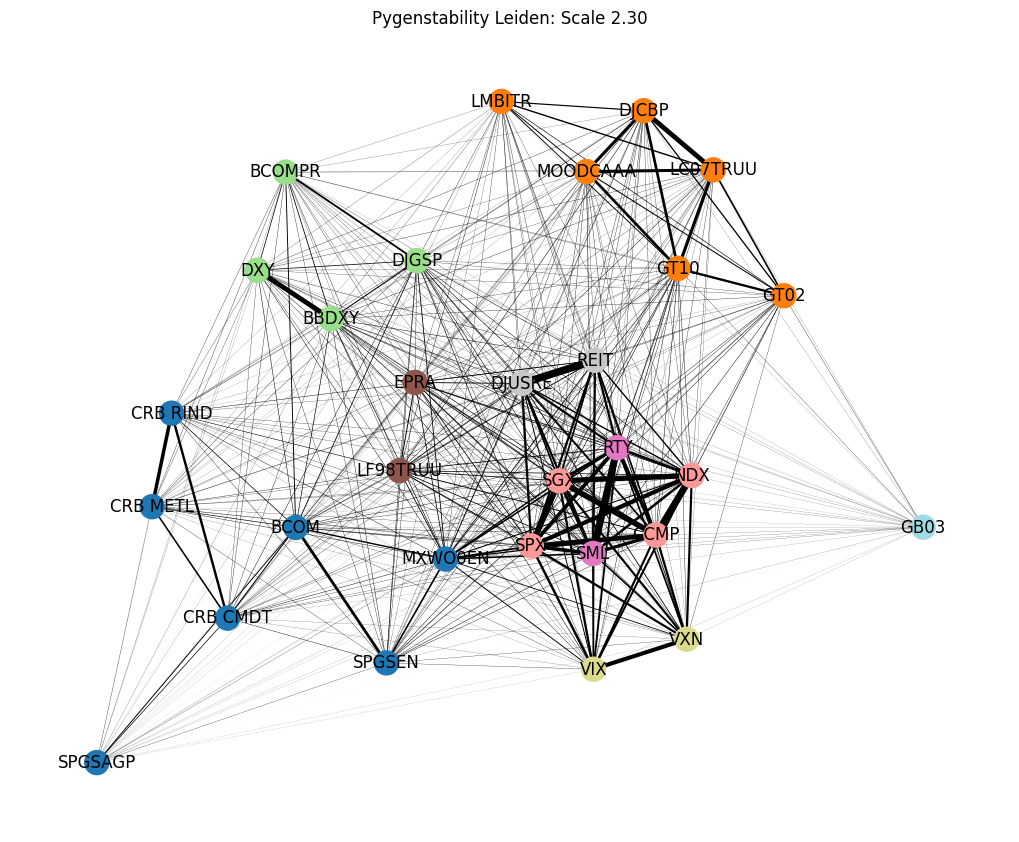

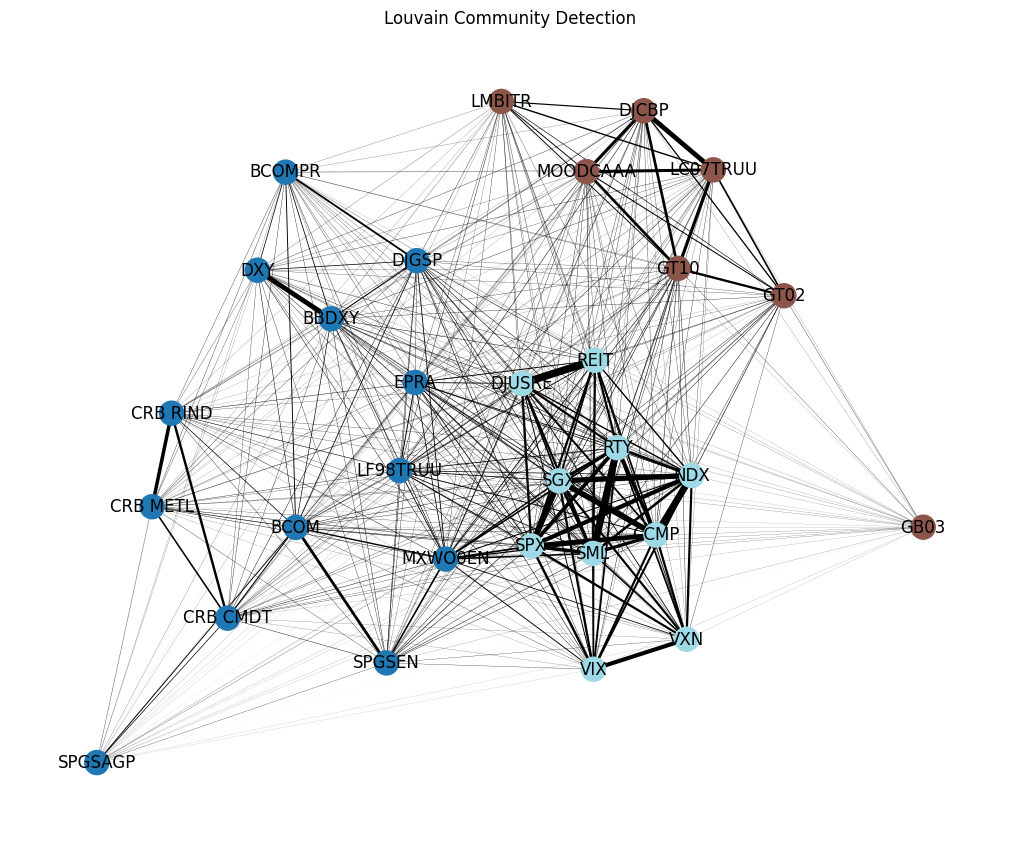

In [9]:
network.custom_plot_communities(mi_network, min_scale=0.6, max_scale=2.5, n_scale=20)

In [10]:
mi_network_nc = network.backbone(mi_network, "mi_network", "noise_corrected", 0.1)
mi_network_dspf = network.backbone(mi_network, "mi_network", "disparity_filter", 0.5)
mi_network_naive = network.backbone(mi_network, "mi_network", "naive_threshold", 0.05)

Calculating NC score...
Calculating DF score...


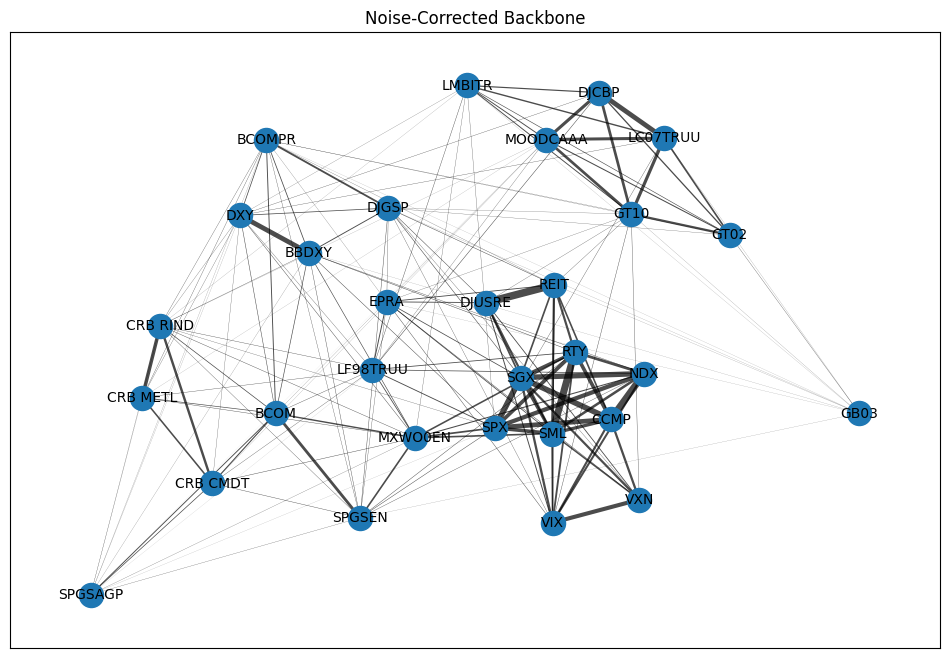

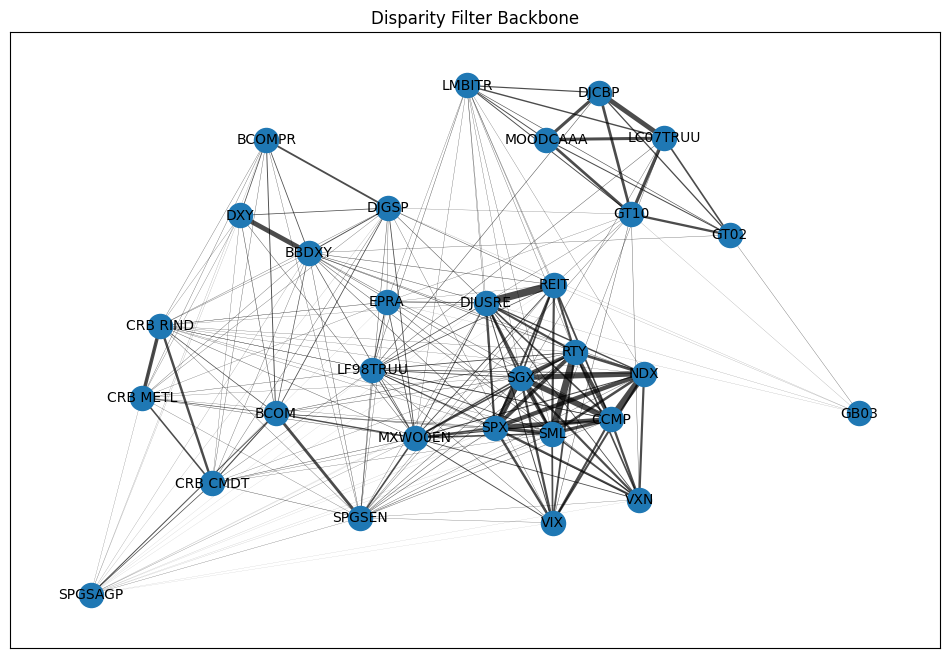

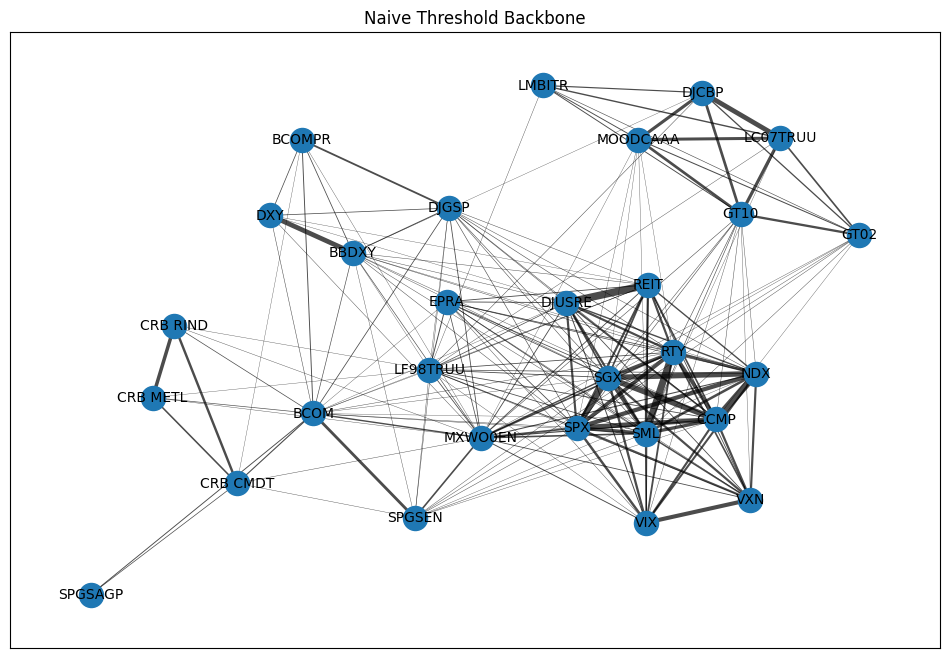

In [13]:
fixed_pos = nx.spring_layout(mi_network, seed=21)
network.plot_graph(mi_network_nc, fixed_pos, title="Noise-Corrected Backbone")
network.plot_graph(mi_network_dspf, fixed_pos, title="Disparity Filter Backbone")
network.plot_graph(mi_network_naive, fixed_pos, title="Naive Threshold Backbone")

In [14]:
network.pgs_optimal_param(mi_network_nc, true_labels, np.linspace(0.3, 0.7, 5))

100%|██████████| 20/20 [00:00<00:00, 637.99it/s]
c:\Users\akhma\OneDrive\Onenote\Python\my_venv\Lib\site-packages\pygenstability\optimal_scales.py:39: RuntimeWarning:

Mean of empty slice



0.5288827168317314


100%|██████████| 20/20 [00:00<00:00, 638.73it/s]


0.5758296324896782


100%|██████████| 20/20 [00:00<00:00, 555.92it/s]


0.6076775073208549


100%|██████████| 20/20 [00:00<00:00, 630.64it/s]


0.6264381294269399


100%|██████████| 20/20 [00:00<00:00, 654.60it/s]


0.6265679613791337


[np.float64(0.5288827168317314),
 np.float64(0.5758296324896782),
 np.float64(0.6076775073208549),
 np.float64(0.6264381294269399),
 np.float64(0.6265679613791337)]

In [15]:
network.pgs_optimal_param(mi_network_dspf, true_labels, np.linspace(0.3, 0.7, 5))

100%|██████████| 20/20 [00:00<00:00, 475.87it/s]
c:\Users\akhma\OneDrive\Onenote\Python\my_venv\Lib\site-packages\pygenstability\optimal_scales.py:39: RuntimeWarning:

Mean of empty slice



0.4490378082282837


100%|██████████| 20/20 [00:00<00:00, 542.65it/s]


0.4406491374676523


100%|██████████| 20/20 [00:00<00:00, 549.90it/s]


0.5653129287581821


100%|██████████| 20/20 [00:00<00:00, 567.09it/s]


0.5884566161496941


100%|██████████| 20/20 [00:00<00:00, 583.92it/s]


0.5658926653233651


[np.float64(0.4490378082282837),
 np.float64(0.4406491374676523),
 np.float64(0.5653129287581821),
 np.float64(0.5884566161496941),
 np.float64(0.5658926653233651)]

In [17]:
def create_network(data, edge="mi", n_surrogates=100):

    G = nx.Graph()
    assets = data.columns

    for asset in assets:
        G.add_node(asset)

    edge_weights = {}

    if edge == "mi":
        for (a1, a2) in itertools.combinations(assets, 2):
            mi = info_theory.MI(data[a1], data[a2])
            
            surrogate_mis =[]
            for _ in range(n_surrogates):
                shift = np.random.randint(1, len(data[a1]))
                shifted_series = np.roll(data[a1], shift)
                mi_surr = info_theory.MI(shifted_series, data[a2])
                surrogate_mis.append(mi_surr)
            mean_surrogate_mi = np.mean(surrogate_mis)
            corrected_mi = mi - mean_surrogate_mi

            if corrected_mi > 0:
                G.add_edge(a1, a2, weight=corrected_mi)
                edge_weights[(a1, a2)] = corrected_mi

    return G


In [18]:
mi_surr_network = create_network(tickers_discrete)

100%|██████████| 30/30 [00:00<00:00, 248.38it/s]


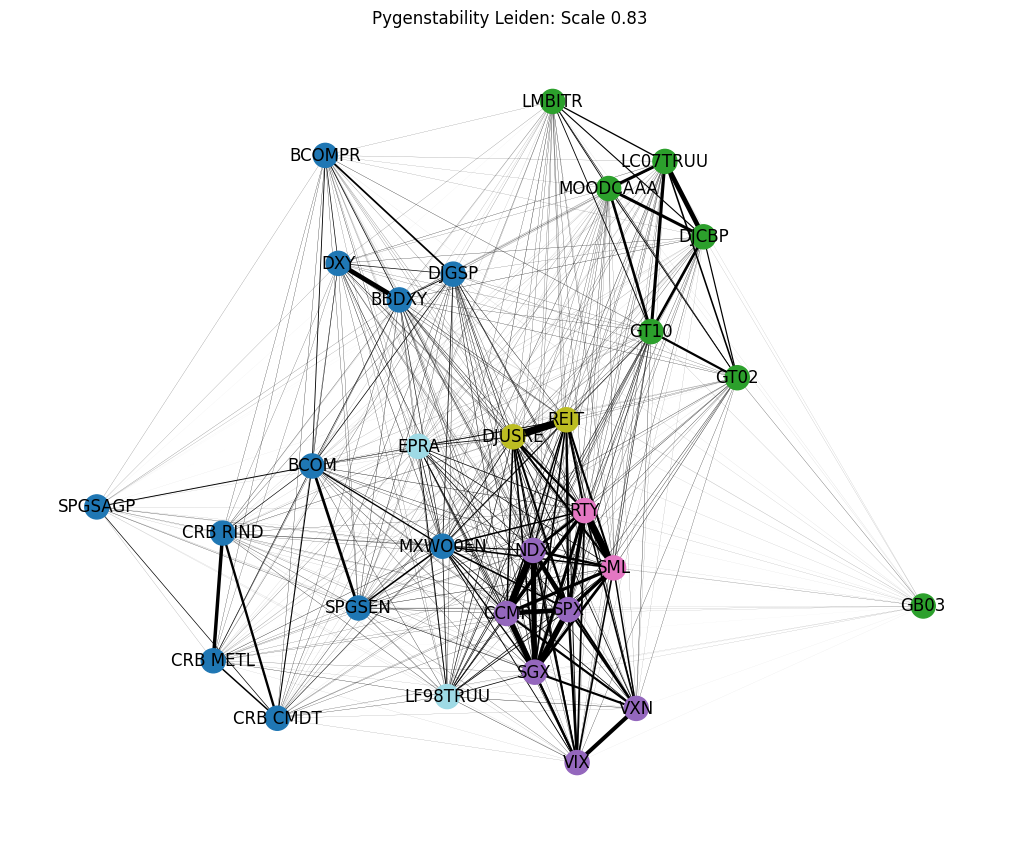

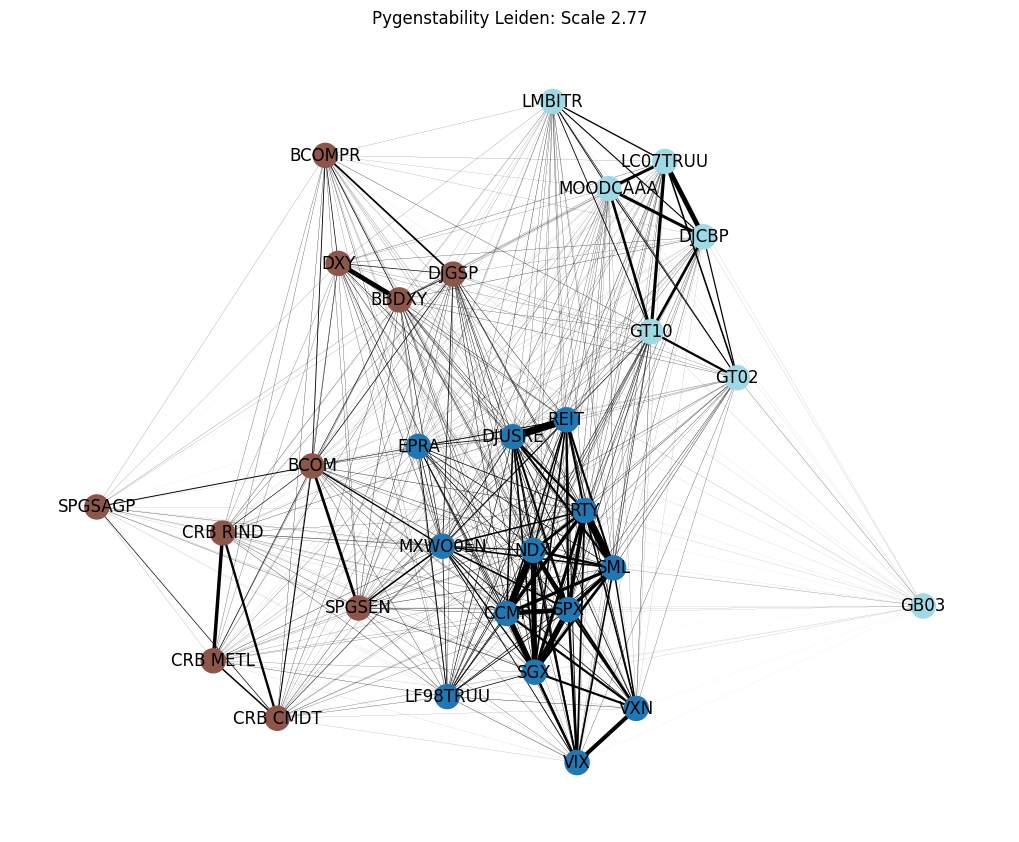

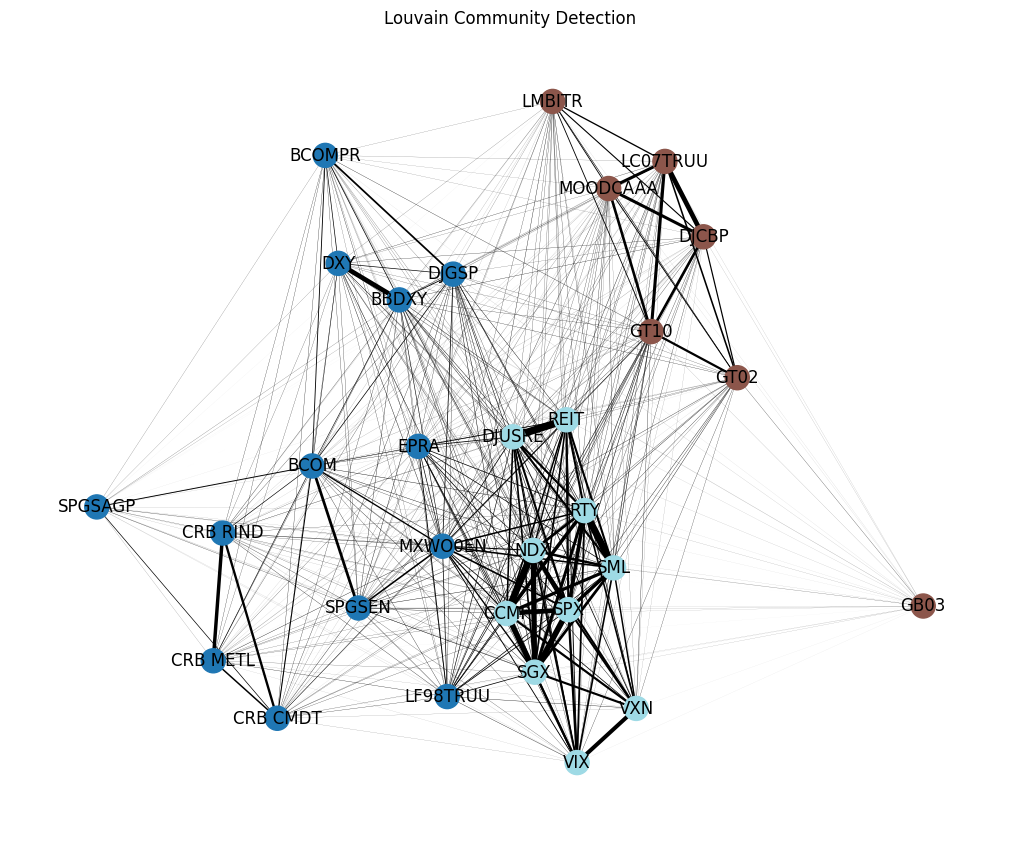

In [19]:
network.custom_plot_communities(mi_surr_network)

In [22]:
network.pgs_optimal_param(mi_surr_network, true_labels, np.linspace(0.3, 0.7, 5))

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 459.47it/s]


0.34093901117720615


100%|██████████| 20/20 [00:00<00:00, 421.25it/s]


0.35202296375091874


100%|██████████| 20/20 [00:00<00:00, 443.34it/s]


0.33234254839651994


100%|██████████| 20/20 [00:00<00:00, 442.62it/s]


0.29961189999546617


100%|██████████| 20/20 [00:00<00:00, 379.76it/s]

0.3531869455106534


[np.float64(0.34093901117720615),
 np.float64(0.35202296375091874),
 np.float64(0.33234254839651994),
 np.float64(0.29961189999546617),
 np.float64(0.3531869455106534)]

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 393.25it/s]


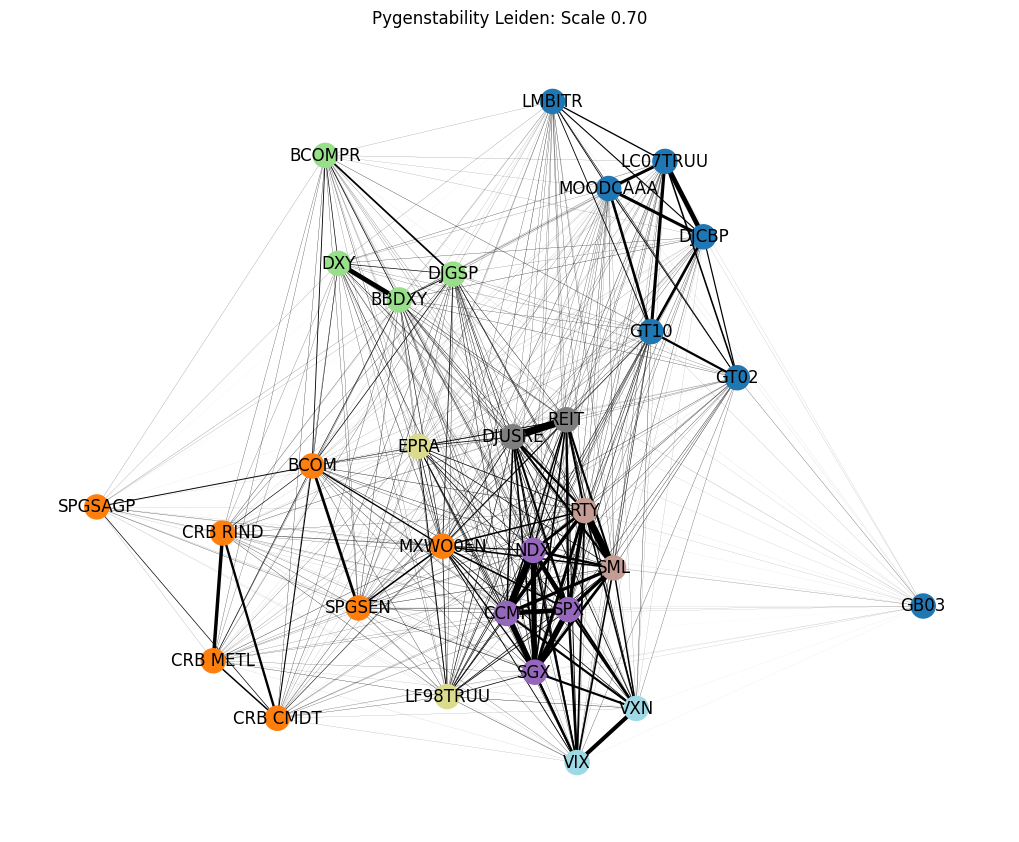

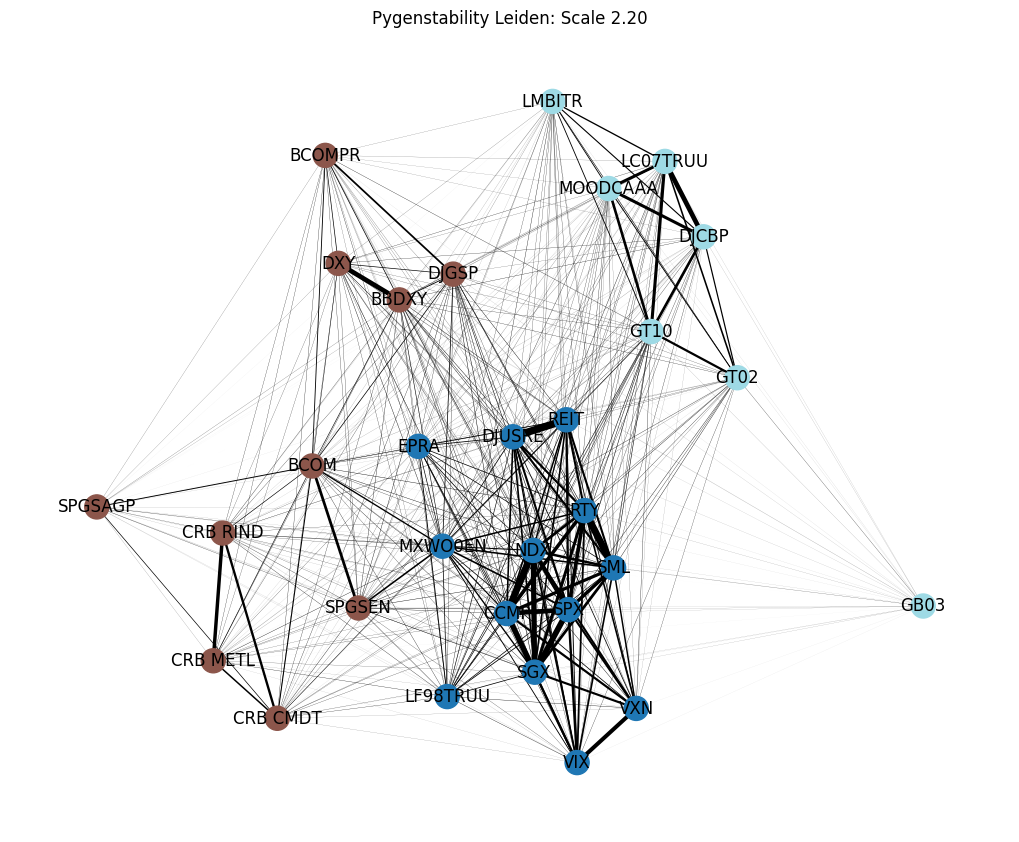

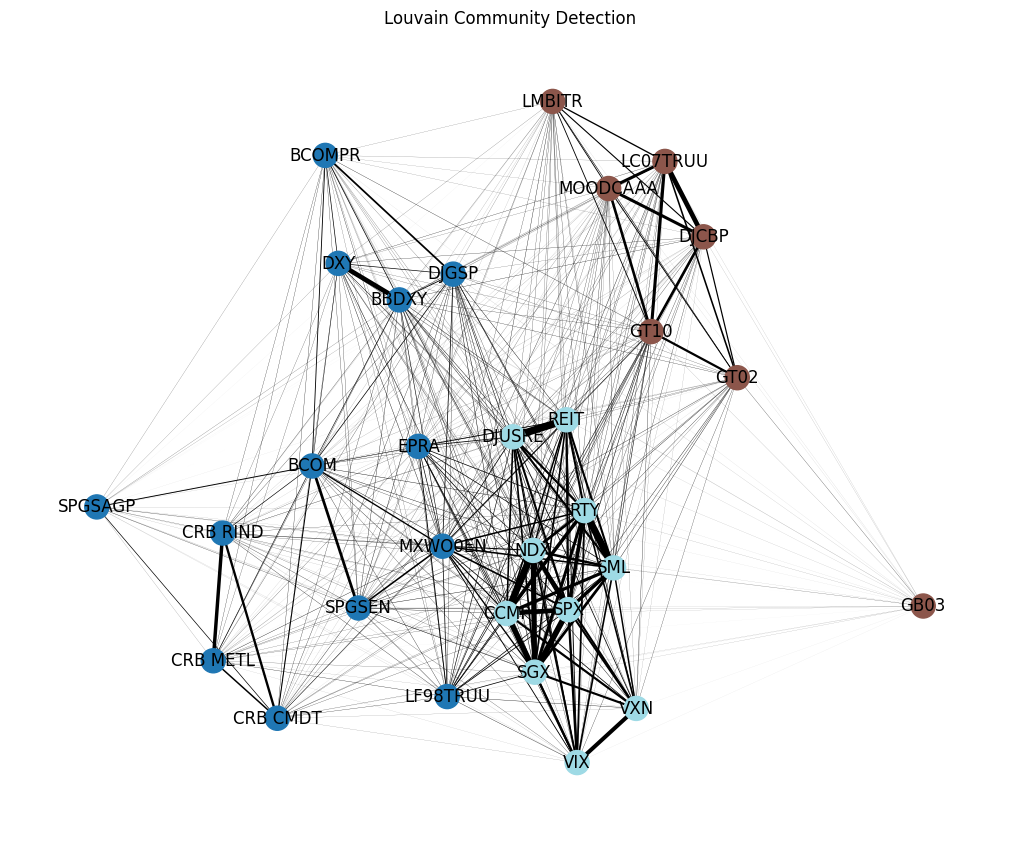

In [24]:
network.custom_plot_communities(mi_surr_network, min_scale=0.6, max_scale=2.5, n_scale=20)